# Домашнее задание «Элементарные методы анализа временных рядов»

В рамках домашнего задания были реализованы функции и классы для элементарных методов анализа временных рядов в файле simple_tsa.py

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt 
from statsmodels.tsa.stattools import adfuller

from simple_tsa import (ts_smooth_plot, simple_moving_average, weighted_moving_average, simple_exponential_smoothing, 
                        DoubleExponentialSmoothing, TripleExponentialSmoothing)

In [2]:
def test_stationarity(timeseries):
    """ Проверка временного ряда на стационарность
    """
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(tseries, lags=None):
    """ Проверка ряда на стационарность и вывод графика автокоррелации и частной автокорреляции
    """
    
    test_stationarity(tseries)
    if not isinstance(tseries, pd.Series):
        tseries = pd.Series(tseries)
        
    with plt.style.context('bmh'):
        
        f, axes = plt.subplots(3, 1, figsize=(14,10))

        series_ax = axes[0]
        acf_ax = axes[1]
        pacf_ax = axes[2]

        tseries.plot(ax=series_ax)

        smt.graphics.plot_acf(tseries, ax=acf_ax, lags=lags, alpha=0.05)
        smt.graphics.plot_pacf(tseries, ax=pacf_ax)

## 1 Приближение и прогнозирование нестационарного временного ряда со статистикой пассажиров авиакомпании

In [3]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
series = airlines_passengers['Count']
airlines_passengers[:12]

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


Проверим характер графика временного ряда и его коррелограммы

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


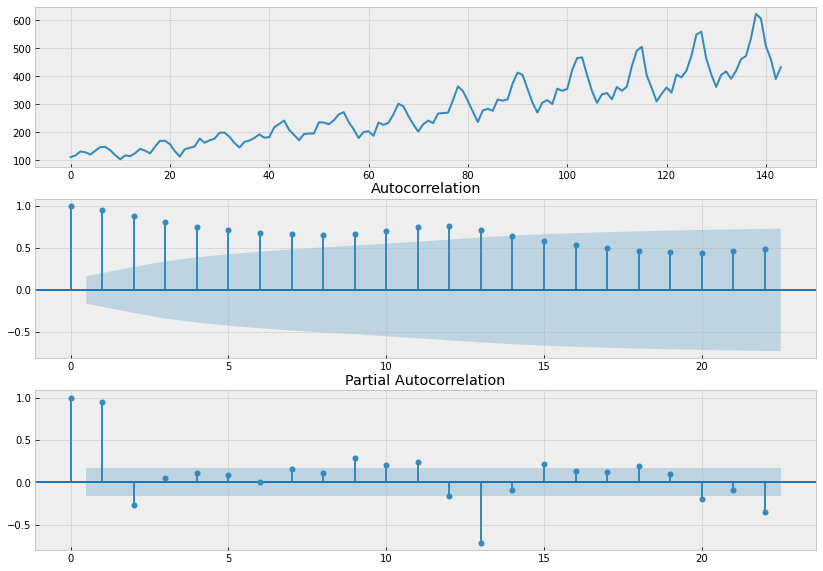

In [4]:
tsplot(series)

Как видно из графиков ряд имеет тренд и сезонность размером в 12 месяцев. При этом обращаем внимание, что со временем увеличивается дисперсия отклонений от тренда для каждого сезона. Это значит, что схема временного ряда имеет мультипликативный характер.

Попробуем сгладить ряд с помощью простого и взвешенного скользящих средних.

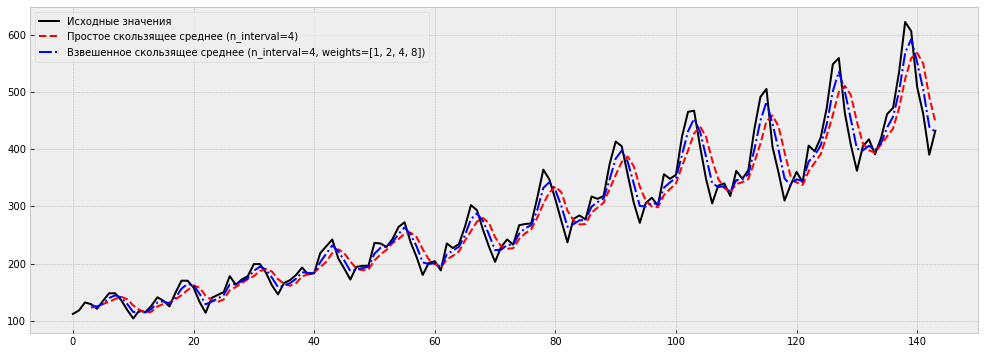

In [5]:
smooth_funcs = {
    "Простое скользящее среднее": {
        'func': simple_moving_average,
        'params': {'n_interval': 4}
    },
    "Взвешенное скользящее среднее": {
        'func': weighted_moving_average,
        'params': {'n_interval': 4, 'weights': [1, 2, 4, 8]}
    }
}
ts_smooth_plot(series, smooth_funcs=smooth_funcs)

Взвешенное среднее более точно описывает наши данные и имеет более низкую задержку. Но с помощью таких методов можно предсказать корректно только одно значение.

Посмотрим как справится экспоненциальное сглаживание.

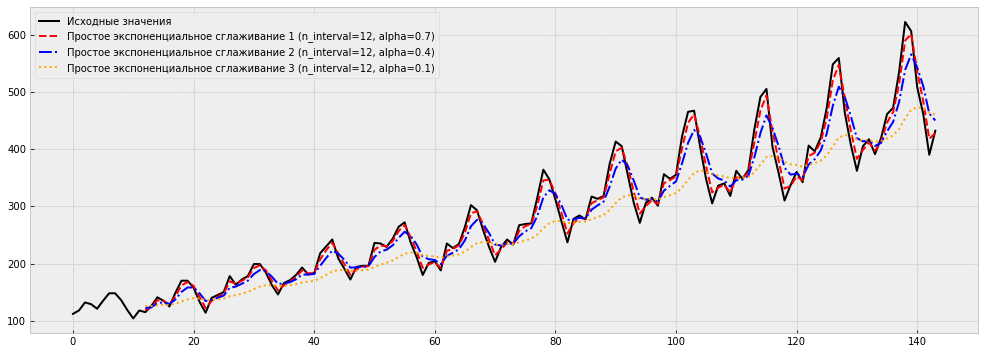

In [6]:
smooth_funcs = {
    "Простое экспоненциальное сглаживание 1": {
        'func': simple_exponential_smoothing,
        'params': {'n_interval': 12, 'alpha': 0.7}
    },
    "Простое экспоненциальное сглаживание 2": {
        'func': simple_exponential_smoothing,
        'params': {'n_interval': 12, 'alpha': 0.4}
    },
    "Простое экспоненциальное сглаживание 3": {
        'func': simple_exponential_smoothing,
        'params': {'n_interval': 12, 'alpha': 0.1}
    },
}
ts_smooth_plot(series, smooth_funcs=smooth_funcs)

Как видно из графиков экспоненциальное сглаживание может более точно повторить наши данные и меет более низкую задержку при высоких коэфициентах. Но этот метод не полдходит для предсказания более чем на один шаг, так как не способен описать тенденцию и сезонность. Предсказания по данному способу на более далекую преспективу подойдут только для рядов в формате y = a0 + E (константа + шум)

Попробуем сгладить данные с помощью двойного экспоненциального сглаживания, которое может учитывать тренды.

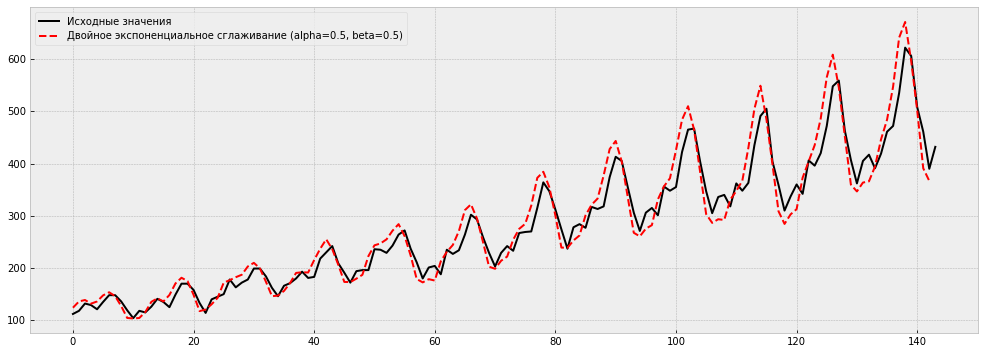

In [7]:
alpha = 0.5
beta = 0.5
dema_model = DoubleExponentialSmoothing(alpha=alpha, beta=beta)
smooth_funcs = {
    f"Двойное экспоненциальное сглаживание (alpha={alpha}, beta={beta})": {
        'func': dema_model.fit,
        'params': {}
    },
}
ts_smooth_plot(series, smooth_funcs=smooth_funcs)

Попробуем определить оптимальные параметры alpha и beta для 6 предсказаний. Нужно учитывать, что модель неспособна предсказывать сезонные колебания и все предсказания больше 1 будут очень неточными. 

In [8]:
prognoz = 6
train, test = series[:-prognoz], series[-prognoz:]

def ema_minimize(X):
    alpha, beta = X
    dema_model = DoubleExponentialSmoothing(alpha=alpha, beta=beta)
    dema_model.fit(train)
    predict = dema_model.predict(n_predicts=len(test))
    error = mean_squared_error(predict[-len(test):], test)
    return error

minimize(ema_minimize, x0=(0,0), method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

      fun: 7581.725945513984
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00090949,  0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 18
     njev: 28
   status: 0
  success: True
        x: array([0.49658888, 0.02100954])

Посмтроим сглаженный ряд вместе с 24 предсказаниями

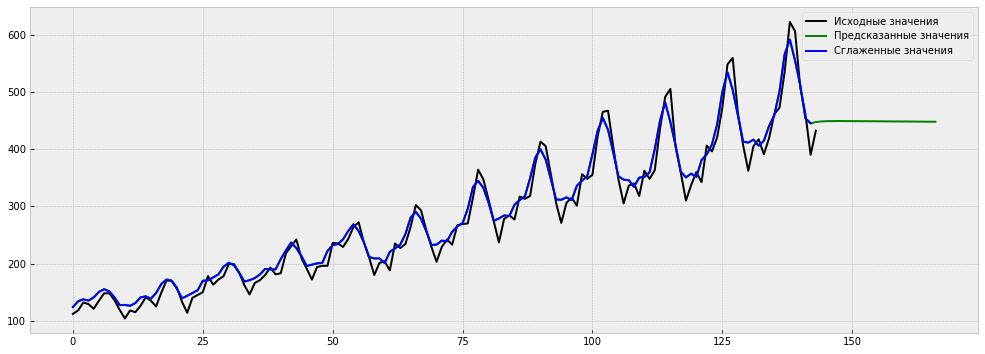

In [9]:
alpha = 0.49658888
beta = 0.02100954
dema_model = DoubleExponentialSmoothing(alpha=alpha, beta=beta)
dema_model.fit(series)
n_predicts = 24
predict_data = dema_model.predict(n_predicts=n_predicts)
with plt.style.context('bmh'):
    plt.figure(figsize=(17,6))
    plt.plot(series, label='Исходные значения', linestyle='-', color='black')
    plt.plot(predict_data, label='Предсказанные значения', linestyle='-', color='green')
    plt.plot(dema_model.smooth_data_, label='Сглаженные значения', linestyle='-', color='blue')
    plt.legend()
    plt.show()

Модели удается адекватно сгладить текущие данные, но с прогнозом на долгосрочную перспективу у нее проблемы, так как не учитывается сезонность.

Теперь попробуем посмотреть модель тройного экспоненциального сглаживания, которая будет учитывать сезонность.
Подберем оптимальные параметры для адитивной и мультипликативной моделей. Плюс эта модель позволяет делать корректные прогнозы на большие промежутки времени, в отличие всех от предыдущих.

In [10]:
prognoz = 24
train, test = series[:-prognoz], series[-prognoz:]
def tema_minimize(X):
    alpha, beta, gamma = X
    model = TripleExponentialSmoothing(alpha=alpha, beta=beta, gamma=gamma, model_type='add', season_len=12)
    predict = model.fit_predict(series=train, n_preds=prognoz)
    error = mean_squared_error(predict[-len(test):], test)
    return error

result = minimize(tema_minimize, x0=(0,0,0), method='L-BFGS-B', bounds = ((0, 1), (0, 1), (0, 1)))
print(result)
print("\nОптимальные параметры для адитивной модели:\n")
print(f"lambda: {result['x'][0]}\nbeta: {result['x'][1]}\ngamma: {result['x'][2]}")

      fun: 506.74649079487745
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.10018719e-03, -1.51071219e+01,  5.18980412e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 324
      nit: 61
     njev: 81
   status: 0
  success: True
        x: array([0.00238315, 1.        , 0.50141991])

Оптимальные параметры для адитивной модели:

lambda: 0.0023831498426448742
beta: 1.0
gamma: 0.5014199143889925


In [11]:
prognoz = 24
train, test = series[:-prognoz], series[-prognoz:]
def tema_minimize(X):
    alpha, beta, gamma = X
    model = TripleExponentialSmoothing(alpha=alpha, beta=beta, gamma=gamma, model_type='mul', season_len=12)
    predict = model.fit_predict(series=train, n_preds=prognoz)
    error = mean_squared_error(predict[-len(test):], test)
    return error

result = minimize(tema_minimize, x0=(0,0,0), method='L-BFGS-B', bounds = ((0, 1), (0, 1), (0, 1)))
print(result)
print("\nОптимальные параметры для мультипликативной модели:\n")
print(f"lambda: {result['x'][0]}\nbeta: {result['x'][1]}\ngamma: {result['x'][2]}")

      fun: 141.13329115759572
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03829825, -0.01451212,  0.0034845 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 272
      nit: 45
     njev: 68
   status: 0
  success: True
        x: array([0.1746761 , 0.51707412, 0.38184398])

Оптимальные параметры для мультипликативной модели:

lambda: 0.17467610372152031
beta: 0.5170741241525788
gamma: 0.3818439833819738


Теперь посмотрим какая модель, адитивная или мультипликативная, лучше описывает и предсказывает данные.
Построим график предсказаний на 24 месяца для адитивной модели.

In [12]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=12, model_type='add'):
    tema = TripleExponentialSmoothing(alpha=alpha, beta=beta, gamma=gamma, model_type=model_type)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema.fit_predict(ser, n_preds=n_preds), color='red', linewidth='4', label='TEMA', alpha=0.3)
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

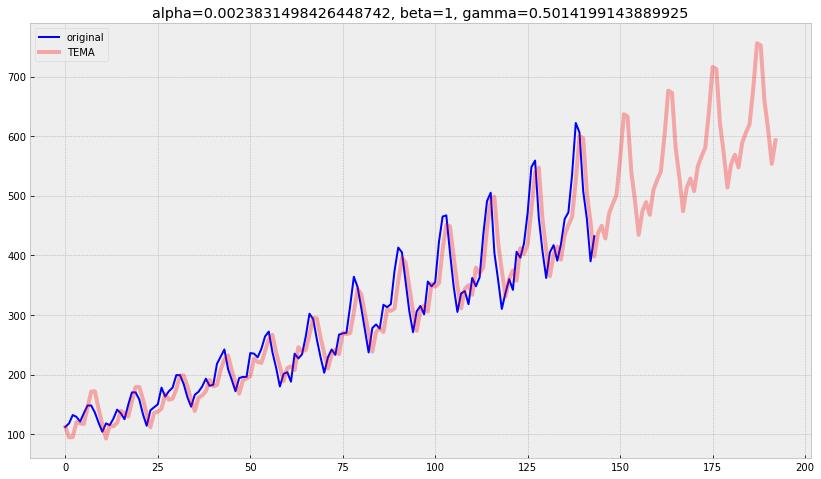

In [13]:
plot_tema(alpha=0.0023831498426448742, beta=1, gamma=0.5014199143889925, 
          ser=series, ser_to_plot=series, model_type='add', n_preds=48)

Как видно модель довольно хорошо построила предсказания, но все предсказанные сезоны имеют одинаковую амплитуду колебаний вокруг тренда. В то время как у временного ряда эта амплитуда увеличивается со временем.

Построим график предсказаний на 24 месяца для мультипликативной модели.

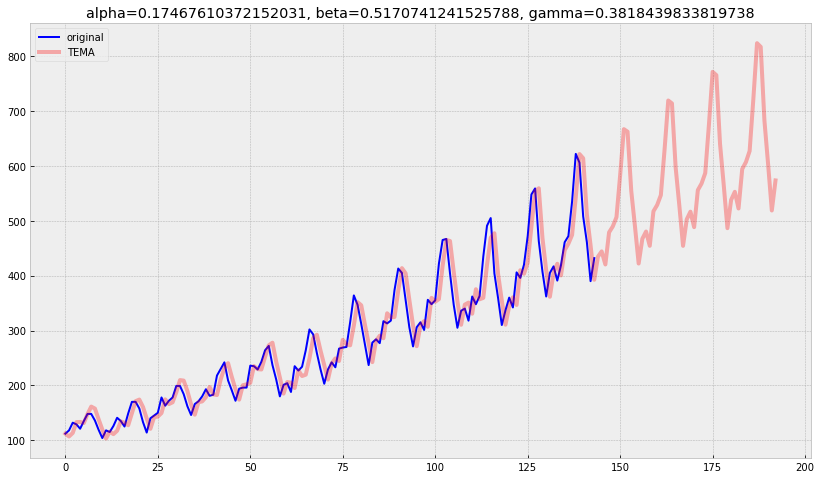

In [14]:
plot_tema(alpha=0.17467610372152031, beta=0.5170741241525788, 
          gamma=0.3818439833819738, ser=series, ser_to_plot=series, model_type='mul', n_preds=48)

Теперь модель стала учитывать тенденцию дисперсии и ее предсказания стали более корректными.

### Вывод
Для текущего датасета самой подходящей моделью является тройной экспоненицалное сглаживания по мультипликативной схеме

## 2 Приближение стационарного временного ряда со статистикой пассажиров авиакомпании

Приведем исходный нестационарный ряд к стационарному

Results of Dickey-Fuller Test:
Test Statistic                -1.606233e+01
p-value                        5.621297e-29
#Lags Used                     1.300000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


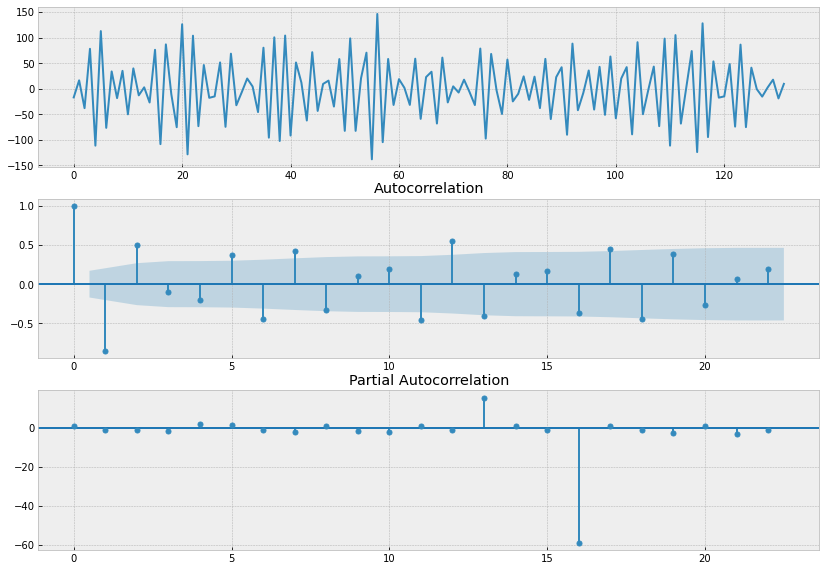

In [15]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
series = airlines_passengers['Count']
series_stationary = boxcox(series, lmbda=0.01)
series_stationary = np.diff(series_stationary, 12)
tsplot(series_stationary)

Проверим как выглядят самые простые способы приближения данных. Для приближения стационарного процесса не подойдут двойное и тройное экспоненциальные сглаживания, так как остутствует тренд и сезонность.

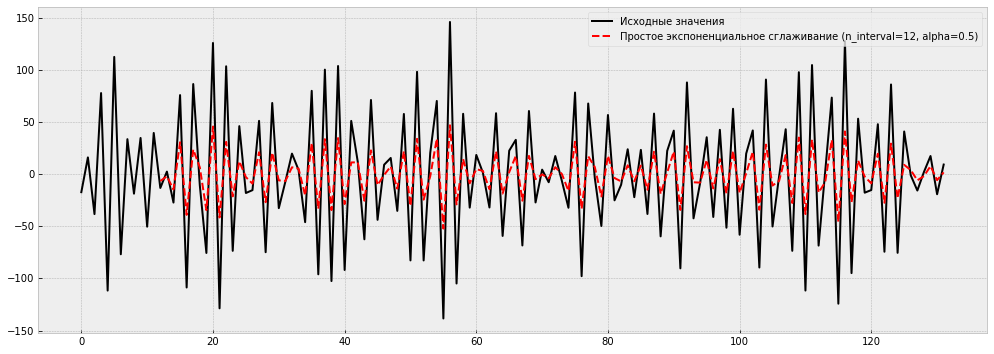

In [16]:
smooth_funcs = {
    "Простое экспоненциальное сглаживание": {
        'func': simple_exponential_smoothing,
        'params': {'n_interval': 12, 'alpha': 0.5}
    },
}
ts_smooth_plot(series_stationary, smooth_funcs=smooth_funcs)

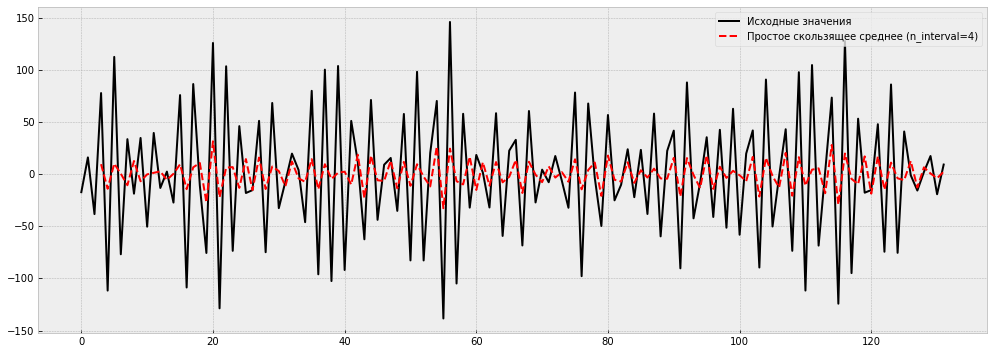

In [17]:
smooth_funcs = {
    "Простое скользящее среднее": {
        'func': simple_moving_average,
        'params': {'n_interval': 4}
    },
}
ts_smooth_plot(series_stationary, smooth_funcs=smooth_funcs)

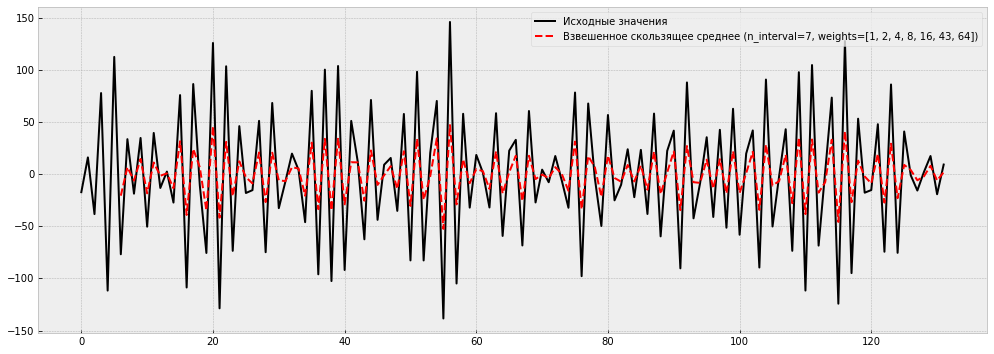

In [18]:
smooth_funcs = {
    "Взвешенное скользящее среднее": {
        'func': weighted_moving_average,
        'params': {'n_interval': 7, 'weights': [1, 2, 4, 8, 16, 43, 64]}
    }
}
ts_smooth_plot(series_stationary, smooth_funcs=smooth_funcs)

По результатам графиков все методы сглаживают примерно одинаково. Если выбирать какой-то один, то можно выбрать простое экспоненциальное среднее.